In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns # statistical visualisation
from statsmodels.tsa.seasonal import seasonal_decompose
import math
from sklearn import preprocessing as pp

%matplotlib inline 
sns.set() # to have nore appealing visualisations

In [2]:
# Reads file at given location
# Returns dataframe corresponding to data in file
def read_file(filepath):
    column_names = [
                    'index', 'date', 'open', 
                    'high', 'low', 'close',
                    'adj_close', 'volume', 
                    'div_amt', 'split_coeff'
                   ]
    df = pd.read_csv(filepath, skiprows=1, header=None, names=column_names, index_col=['date'], parse_dates=['date'])
    df.drop(columns=['index'], inplace=True)
    return df

filepath = '../data/alphaVantage/DJI-full-daily_adjusted.csv'
stocks = read_file(filepath)
print(stocks.info())
stocks.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4731 entries, 2018-10-19 to 2000-01-03
Data columns (total 8 columns):
open           4731 non-null float64
high           4731 non-null float64
low            4731 non-null float64
close          4731 non-null float64
adj_close      4731 non-null float64
volume         4731 non-null int64
div_amt        4731 non-null float64
split_coeff    4731 non-null float64
dtypes: float64(7), int64(1)
memory usage: 332.6 KB
None


,open,high,low,close,adj_close,volume,div_amt,split_coeff
date,,,,,,,,
2018-10-19,25421.0898,25608.7109,25350.0195,25444.3398,25444.3398,350810000,0.0,1.0
2018-10-18,25645.5605,25691.4609,25236.0098,25379.4492,25379.4492,328020000,0.0,1.0
2018-10-17,25705.8691,25810.0898,25479.1602,25706.6797,25706.6797,298210000,0.0,1.0
2018-10-16,25351.5293,25817.6797,25351.5293,25798.4199,25798.4199,305800000,0.0,1.0
2018-10-15,25332.4609,25482.4199,25243.8809,25250.5508,25250.5508,287320000,0.0,1.0


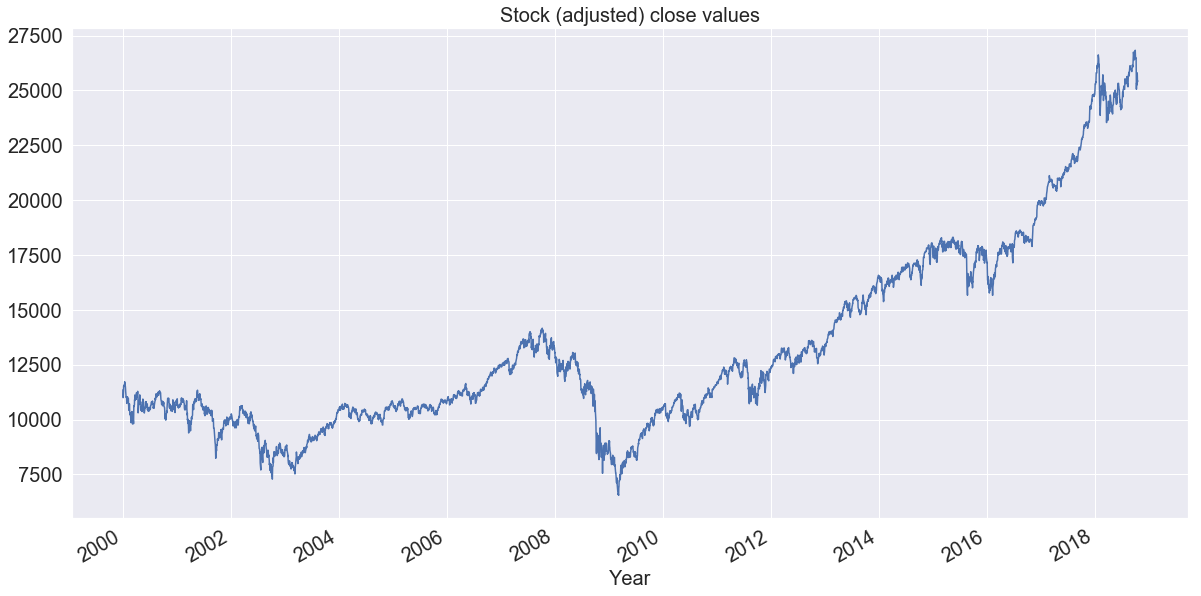

In [32]:
def visualise_plot(df, param, title):
    df[param].plot(figsize=(20,10), fontsize=20)
    plt.xlabel('Year', fontsize=20)
    plt.title(title, fontsize=20)
    plt.show()
    
visualise_plot(stocks, 'adj_close', 'Stock (adjusted) close values')

## Converting to Returns

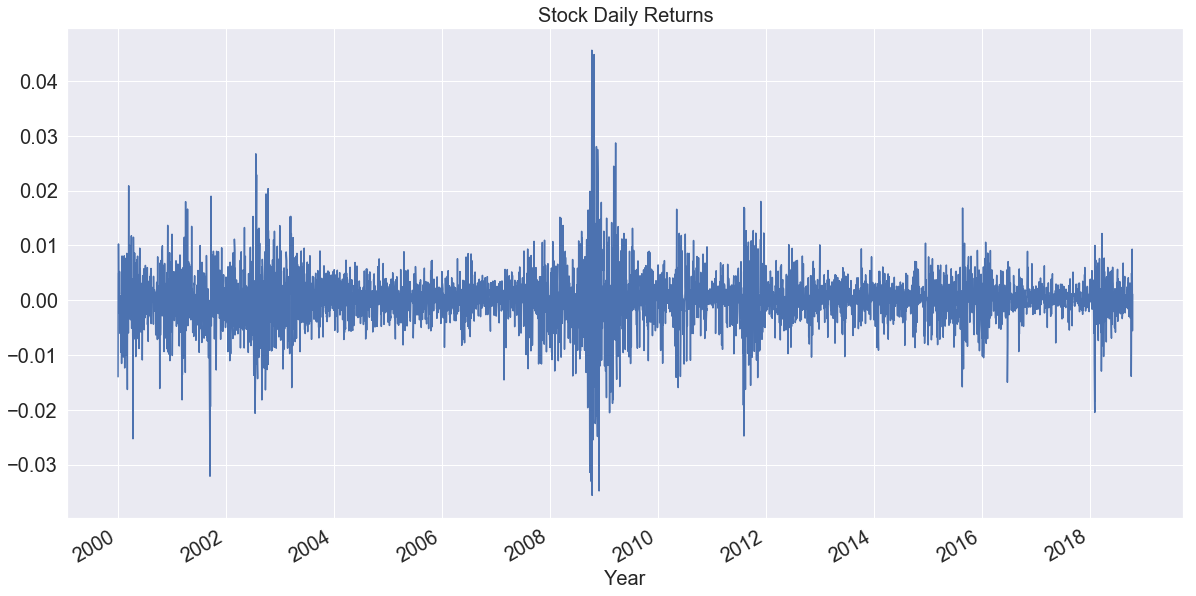

           returns
count  4730.000000
mean      0.000074
std       0.004916
min      -0.035614
25%      -0.001999
50%       0.000204
75%       0.002353
max       0.045637


,returns
2018-10-19,0.001109
2018-10-18,-0.005564
2018-10-17,-0.001547
2018-10-16,0.009322
2018-10-15,-0.001536


In [4]:
# Returns the daily returns of the stock (Using Taylor series approximation)
def data_log_returns(data):
    log_returns = list()
    date = list()
    for i in range(len(data) - 1):
        abs_t1 = math.log10(data.loc[data.index[i], "adj_close"])
        abs_t0 = math.log10(data.loc[data.index[i + 1], "adj_close"])
        log_returns.append(abs_t1 - abs_t0)
        date.append(data.index[i])
    return pd.DataFrame(log_returns, index=date, columns=['returns'])

stock_returns = data_log_returns(stocks)
visualise_plot(stock_returns, 'returns', 'Stock Daily Returns')
print(stock_returns.describe())
stock_returns.head()

## Scaling
### 1. Standard Scaling

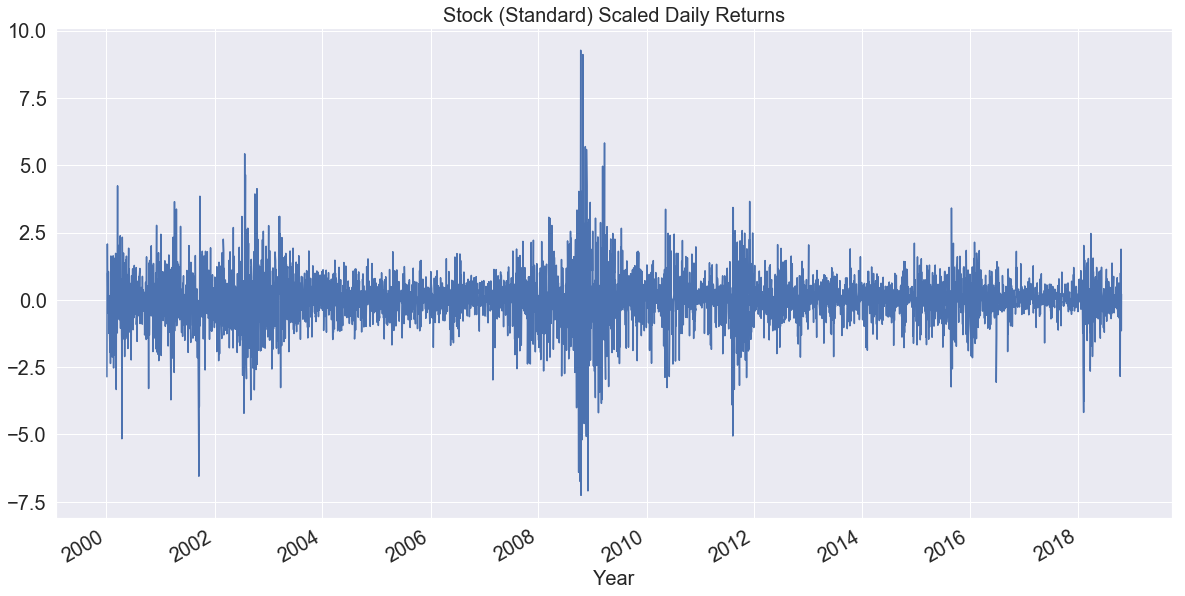

            returns
count  4.730000e+03
mean  -2.027976e-17
std    1.000106e+00
min   -7.259733e+00
25%   -4.217386e-01
50%    2.637232e-02
75%    4.635677e-01
max    9.268438e+00


,returns
2018-10-19,0.210526
2018-10-18,-1.146851
2018-10-17,-0.329780
2018-10-16,1.881265
2018-10-15,-0.327434


In [5]:
# Standard Scaling the data to get 0 mean and 1 Standard Deviation
def standard_scaling_data(data):
    temp = data
    standardScaler = pp.StandardScaler()
    column_names = temp.columns
    standardScaler.fit(temp)
    data = pd.DataFrame(standardScaler.transform(temp), 
                        index=data.index, 
                        columns = column_names)
    return data

std_scaled_stock_returns = standard_scaling_data(stock_returns)
visualise_plot(std_scaled_stock_returns, 'returns', 'Stock (Standard) Scaled Daily Returns')
print(std_scaled_stock_returns.describe())
std_scaled_stock_returns.head()

### 2. Min-Max Scaling

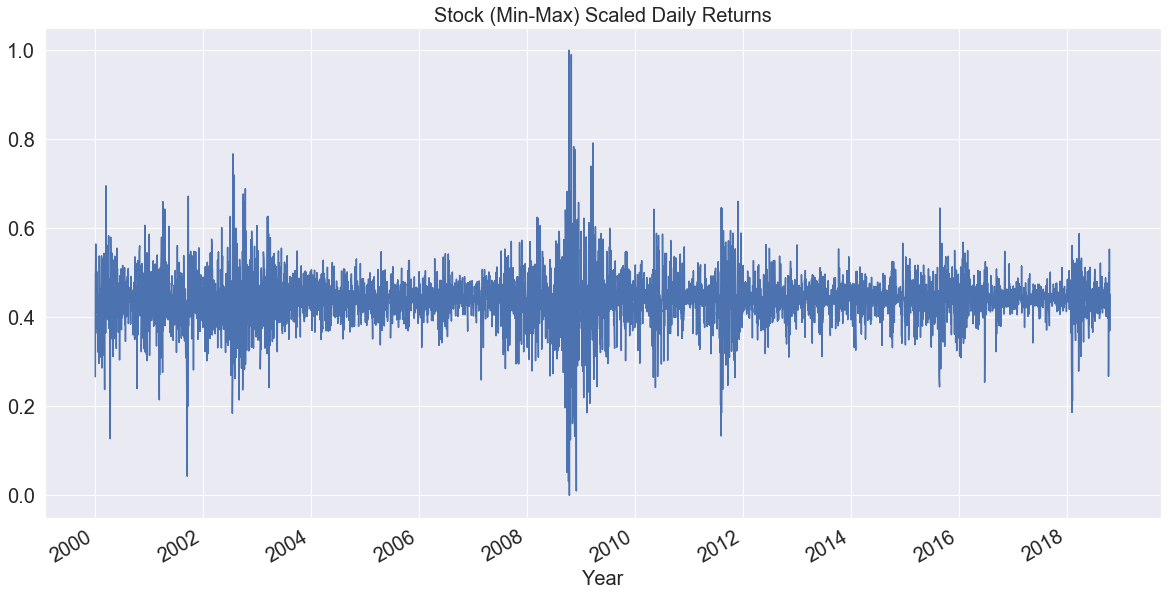

           returns
count  4730.000000
mean      0.439234
std       0.060509
min       0.000000
25%       0.413718
50%       0.440830
75%       0.467281
max       1.000000


,returns
2018-10-19,0.451971
2018-10-18,0.369846
2018-10-17,0.419281
2018-10-16,0.553056
2018-10-15,0.419423


In [6]:
# Standard Scaling the data to get 0 mean and 1 Standard Deviation
def min_max_scaling_data(data):
    temp = data
    minMaxScaler = pp.MinMaxScaler(feature_range=(0,1))
    column_names = temp.columns
    temp = minMaxScaler.fit_transform(temp)
    data = pd.DataFrame(temp, index=data.index, columns = column_names)
    return data

minmax_scaled_stock_returns = min_max_scaling_data(stock_returns)
visualise_plot(minmax_scaled_stock_returns, 'returns', 'Stock (Min-Max) Scaled Daily Returns')
print(minmax_scaled_stock_returns.describe())
minmax_scaled_stock_returns.head()

## Decomposition
### 1. Using statsmodel sesasonal_deocmpose
Basics - https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

Frequency adjustment - https://stackoverflow.com/a/47610117

In [21]:
df = stocks
decomposition_param = 'adj_close'
# df = std_scaled_stock_returns
# df = minmax_scaled_stock_returns
# decomposition_param = 'returns'

Additive Decomposition:


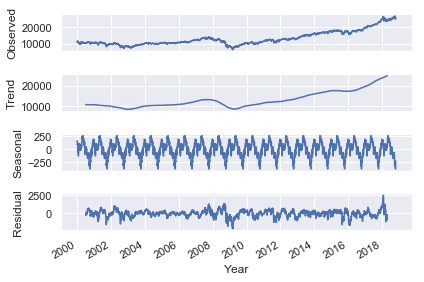

Additive: Seasonlity and Residue
Multiplicative Decomposition:


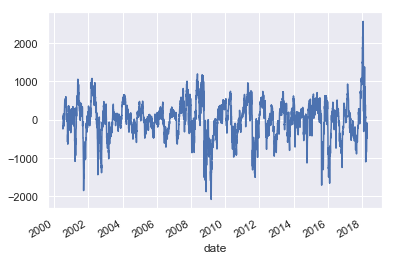

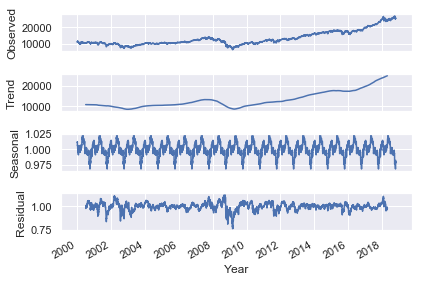

Multiplicative: Seasonlity and Residue


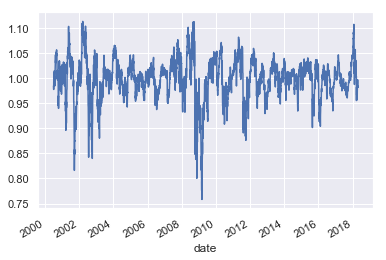

In [23]:
# Uses statsmodel sesasonal_deocmpose to plot the 
# trend, seasonality and residue of the dataframe
def series_decomposition(df, param, model):
    result = seasonal_decompose(df[param], model=model, freq=252)
    result.plot()
    plt.xlabel('Year')
    plt.show()
    return result

print('Additive Decomposition:')    
add_decom = series_decomposition(df, decomposition_param, 'additive')
print('Additive: Seasonlity and Residue')
(add_decom.seasonal + add_decom.resid).plot()


print('Multiplicative Decomposition:')    
mult_decom = series_decomposition(df, decomposition_param, 'multiplicative')
print('Multiplicative: Seasonlity and Residue')
(mult_decom.seasonal*mult_decom.resid).plot()

### 2. Rolling Average Trend

In [38]:
df = stocks
decomposition_param = 'adj_close'
# df = std_scaled_stock_returns
# df = minmax_scaled_stock_returns
# decomposition_param = 'returns'

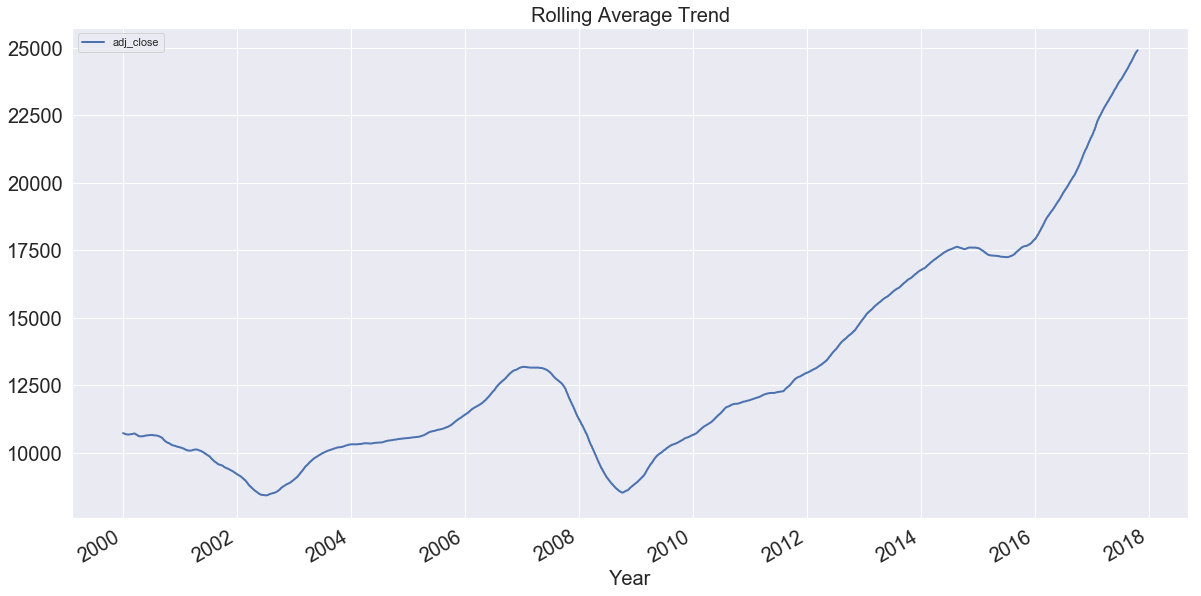

In [39]:
daily_returns = df[[decomposition_param]]
# window size of 252 days rolling around a year (Number of trading days in a year = 252)
daily_returns.rolling(252).mean().plot(figsize=(20,10), linewidth=2, fontsize=20) 
# plotting the trend
plt.title("Rolling Average Trend", fontsize=20)
plt.xlabel('Year', fontsize=20);

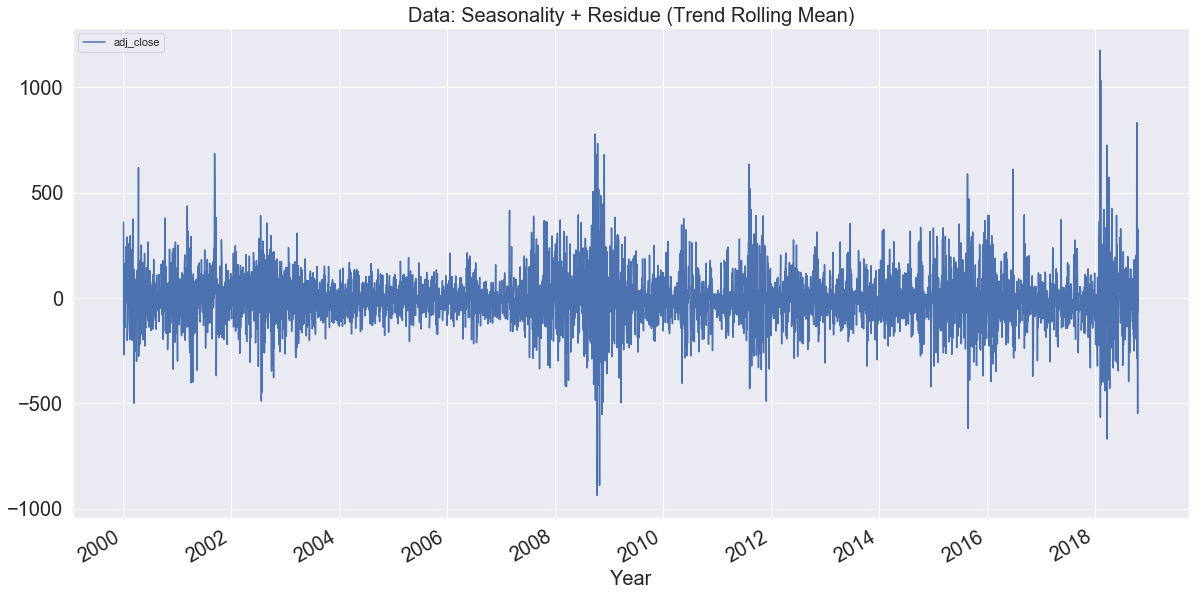

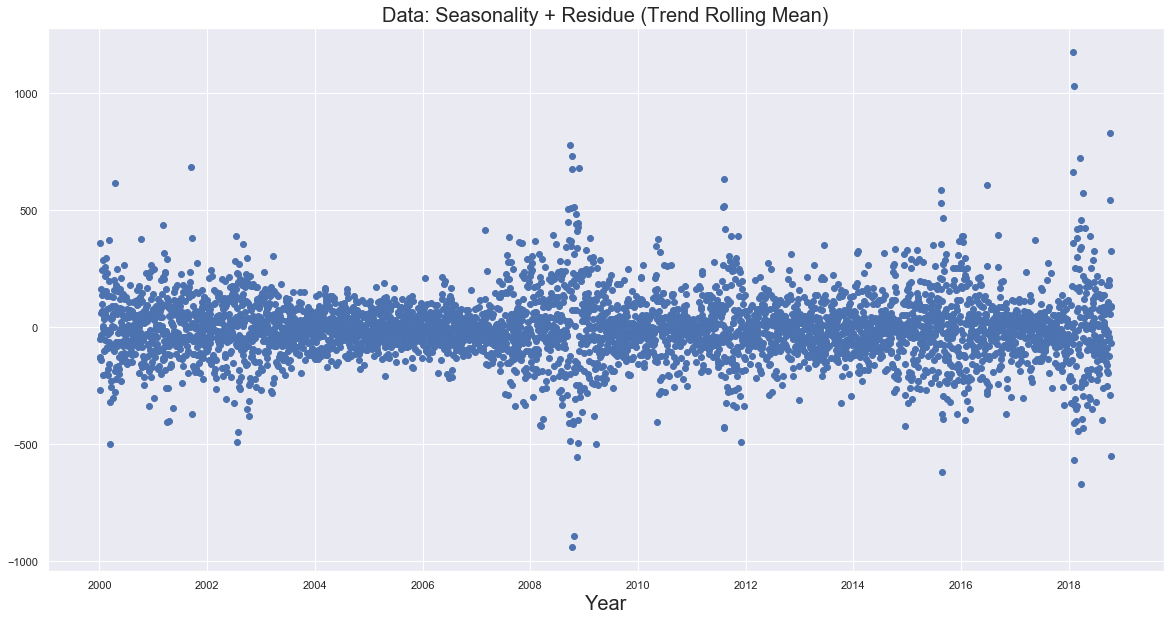

In [40]:
# Removing the trend (to see the seasonality and noise)

daily_returns.diff().plot(figsize=(20,10), fontsize=20)
plt.title('Data: Seasonality + Residue (Trend Rolling Mean)', fontsize=20)
plt.xlabel('Year', fontsize=20);

# Scatter Plot
plt.figure(figsize=(20, 10))
plt.scatter(daily_returns.index, daily_returns.diff())
plt.title('Data: Seasonality + Residue (Trend Rolling Mean)', fontsize=20)
plt.xlabel('Year', fontsize=20);

In [54]:
df[decomposition_param].diff().autocorr(lag=1)

-0.05305445350045931

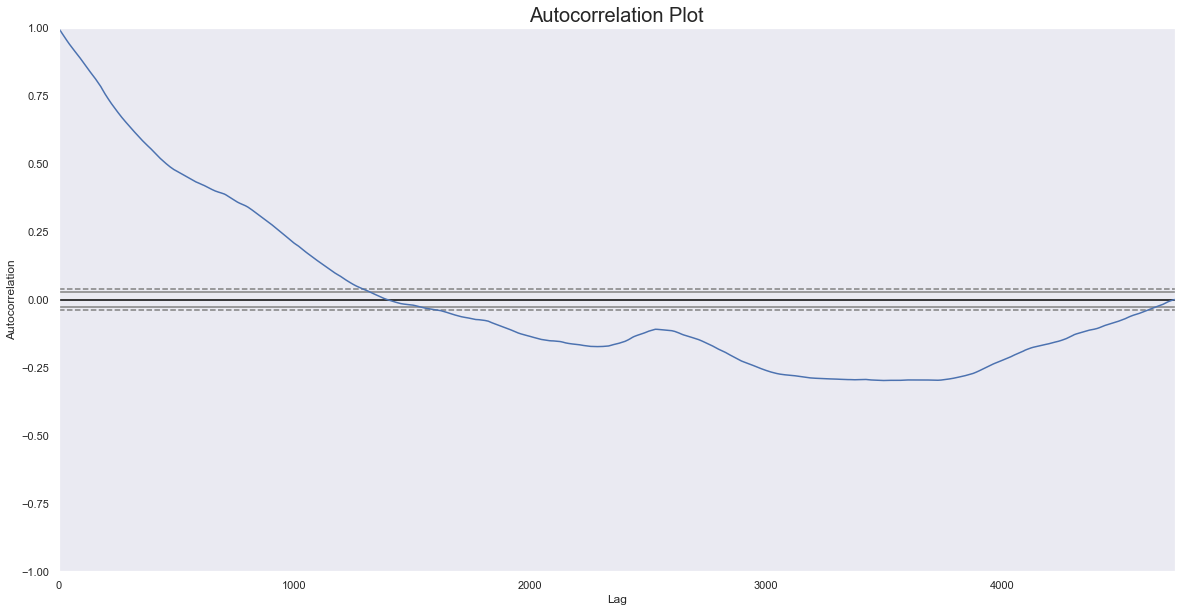

In [50]:
plt.figure(figsize=(20,10))
pd.plotting.autocorrelation_plot(daily_returns)
plt.title('Autocorrelation Plot', fontsize=20);